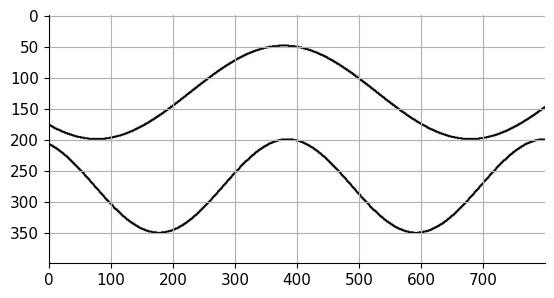

(1000, 400, 800)


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.signal import argrelextrema
from tqdm import tqdm
from scipy.special import factorial

# Set rcParams to customize tick labels and spines
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.grid'] = True
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['legend.loc'] = 'upper right'
plt.rcParams['axes.titlesize'] = 12

source_directory = f"D:/Courses/Uclouvain/thesis/code/thesis_Colin/seismogram_curve_extraction/data_2_traces/sines/overlap_0-00/"
signals_directory = source_directory + f"signals/"
GTs_filepath = source_directory + f"ground_truth/"

def load_images_from_folder(folder, N_show):
    # set N_show to 0 not to show any images
    saved_images = []  # List to store images
    count = 0
    for image_file in os.listdir(folder):
        image_file = os.path.join(folder, image_file)
        saved_images.append(cv2.imread(image_file, cv2.IMREAD_GRAYSCALE))
        if count < N_show:
            plt.imshow(cv2.imread(image_file, cv2.IMREAD_GRAYSCALE), cmap='gray')
            plt.show()
            count += 1

    return np.array(saved_images)

saved_images = load_images_from_folder(signals_directory, 0)

# Get the ROI of the images
def get_roi(image):
    temp_image = - (image - np.max(image))
    # Get the row and column indices of the non-zero elements
    rows, cols = np.nonzero(temp_image)
    # Get the minimum and maximum row and column indices
    min_row, max_row = np.min(rows), np.max(rows)
    min_col, max_col = np.min(cols), np.max(cols)
    # Get the ROI of the image
    roi = image[min_row:max_row + 1, min_col:max_col + 1]
    return roi

plt.imshow(saved_images[0], cmap='gray')
plt.show()

# # Get the ROI of all the images
# new_saved_images = []
# for image in saved_images:
#     new_saved_images.append(np.array(get_roi(image)))

# saved_images = new_saved_images

print(saved_images.shape)

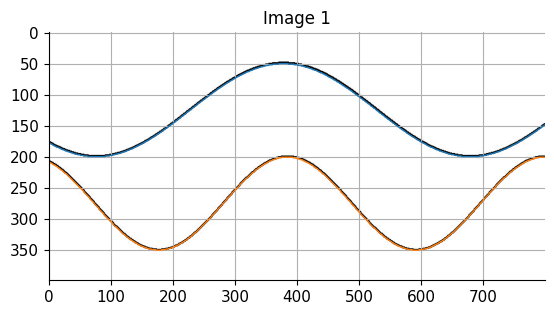

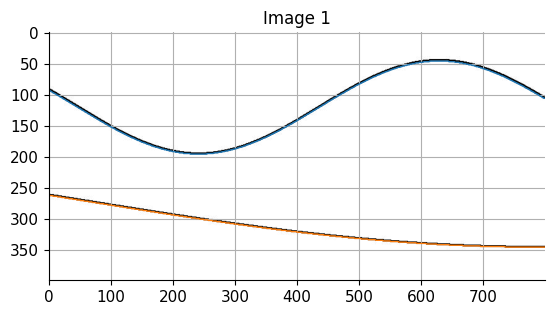

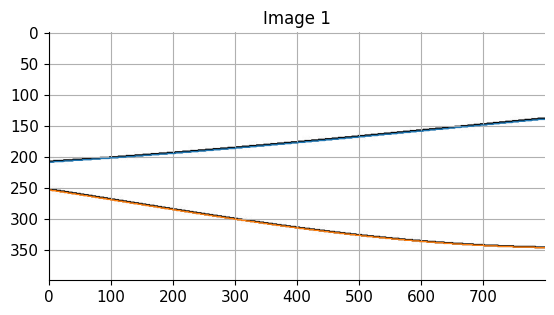

In [4]:
# Load the GTs
GTs_filepath = source_directory + f"ground_truth/"

# Get the list of .npy files in the folder
file_list = [file_name for file_name in os.listdir(GTs_filepath) if file_name.endswith(".npy")]

# Pre-allocate the ground_truths array
num_files = len(file_list)
first_signal = np.load(os.path.join(GTs_filepath, file_list[0]))
GTs = np.zeros((num_files, first_signal.shape[0], first_signal.shape[1]))

# Iterate over the files in the folder
for file_name in file_list:
    # Extract the index from the filename
    idx = int(file_name.split('_')[1].split('.')[0])
    # Load the numpy array
    temp = np.load(os.path.join(GTs_filepath, file_name))
    GTs[idx] = temp

GTs_norm = GTs / saved_images.shape[1]

# plot the GTs above the images
for idx in range(len(saved_images)):
    if idx < 3:
        plt.imshow(saved_images[idx], cmap='gray')
        for i in range(GTs[idx].shape[0]):
            plt.plot(np.arange(GTs[idx].shape[1]), GTs[idx, i], linewidth=1)
        plt.title(f"Image {i}")
        plt.show()

In [5]:
print(GTs.shape)

(1000, 2, 800)


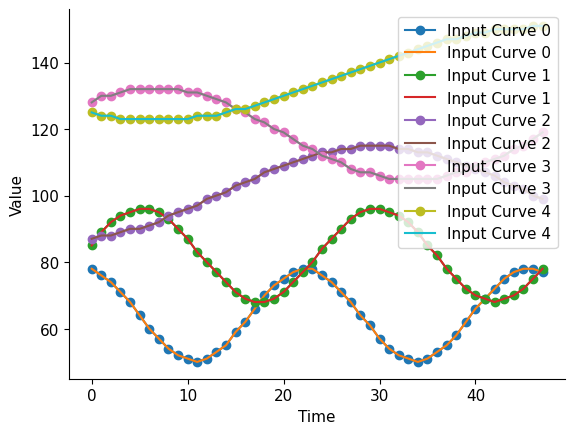

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from scipy.optimize import linear_sum_assignment

# torch.manual_seed(0)

# -------------------------------
# Synthetic Data Generator
# -------------------------------
def generate_data(all_GTs):
    """
    Generate synthetic time-series data based on the provided ground truth signals.
    Args:
        all_GTs (numpy.ndarray): Array of shape (num_samples, N_curves, seq_length) representing the ground truth signals.
    Returns:
        X (torch.Tensor): Input data of shape (num_samples, seq_length-1, N_curves).
        Y (torch.Tensor): Target data of shape (num_samples, seq_length-1, N_curves)."""
    num_samples, N_curves, seq_length = all_GTs.shape

    X = torch.zeros(num_samples, seq_length-1, N_curves)
    Y = torch.zeros(num_samples, seq_length-1, N_curves)
    for i in range(num_samples):
        for j in range(N_curves):
            X[i, :, j] = torch.tensor(all_GTs[i, j, :-1])
            Y[i, :, j] = torch.tensor(all_GTs[i, j, 1:])
    # # Add noise to the data
    # noise = torch.randn_like(X) * 0.1
    # X += noise
    # Y += noise
    # # Normalize the data 
    return X, Y

# -------------------------------
# Custom Dataset for Time-Series Data
# -------------------------------
class TimeSeriesDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X  # shape: (num_samples, seq_len, N_curves)
        self.Y = Y  # shape: (num_samples, seq_len, N_curves)
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

X_train, Y_train = generate_data(GTs) # shape: (num_samples, seq_length-1, N_curves)
for i in range(X_train.shape[2]):
    plt.plot(X_train[0, 1:, i].numpy(), label=f'Input Curve {i}', marker='o')
    plt.plot(Y_train[0, :-1, i].numpy(), label=f'Input Curve {i}')
plt.grid()
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

In [5]:

# -------------------------------
# Linear RNN Model
# -------------------------------
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        
        # Using batch_first=True, so input and output are (batch, seq_len, feature)
        self.rnn = nn.RNN(input_size, hidden_size, bias=True, batch_first=True, nonlinearity='tanh')
        self.output_layer = nn.Linear(hidden_size, output_size, bias=True)
    
    def forward(self, measurement, hidden):
        # measurement: expected shape (batch, input_size)
        # Unsqueeze to get shape (batch, 1, input_size)
        if measurement.dim() == 2:
            measurement = measurement.unsqueeze(1)
        output_seq, hidden_new = self.rnn(measurement, hidden)
        # Use the last hidden state for prediction; shape: (batch, hidden_size)
        prediction = self.output_layer(hidden_new[-1])
        return prediction, hidden_new

    def init_hidden(self, batch_size=1, GTs_init=None):
        """
        Initialize the hidden state of the RNN.
        Args:
            batch_size (int): The size of the batch.
            GTs_init (torch.Tensor): Optional initial hidden state, shape: (batch_size, hidden_size).
        """
        # Hidden shape: (num_layers, batch, hidden_size)
        if GTs_init is not None:
            # Initialize hidden state with GTs_init
            hidden = torch.zeros(1, batch_size, self.hidden_size)
            hidden[0] = GTs_init
            return hidden
        else:
            return torch.zeros(1, batch_size, self.hidden_size)
    
# -------------------------------
# Helper: Predict a Sequence on a Single Sample
# -------------------------------
def predict_sequence(model, sample_measurements, pred_mat, N_curves):
    """
    Given a single sample of ground-truth measurements (shape: [seq_len, N_curves]),
    this function runs the trained model to predict the next positions over time.
    """
    # Initialize hidden state using the first measurement.
    hidden = model.init_hidden(batch_size=1)
    hidden[0, 0, :N_curves] = sample_measurements[0, :]
    hidden[0, 0, N_curves:] = sample_measurements[0, :]
    
    predicted_positions = []
    # Loop from t=1 to the end of the sequence
    for t in range(1, sample_measurements.shape[0]):
        current_measurement = sample_measurements[t, :].unsqueeze(0)  # shape: (1, N_curves)
        with torch.no_grad():
            hidden_b = hidden[0, 0]  # shape: (hidden_size,)
            predicted_state = (pred_mat @ hidden_b.unsqueeze(1)).cpu().numpy()  # shape: (N_curves, 1)
            meas_b = current_measurement.cpu().numpy().reshape(1, -1)            # shape: (1, N_curves)
            cost_matrix = np.abs(predicted_state - meas_b)                       # shape: (N_curves, N_curves)
            row_ind, col_ind = linear_sum_assignment(cost_matrix)
            assigned = np.zeros(N_curves)
            for r, c in zip(row_ind, col_ind):
                assigned[r] = current_measurement[0, c].item()
            assigned_measurement = torch.tensor(assigned, dtype=torch.float32).unsqueeze(0)
        prediction, hidden = model(assigned_measurement, hidden)
        predicted_positions.append(prediction[:, :N_curves])
    predicted_seq = torch.cat(predicted_positions, dim=0)  # shape: (seq_len-1, N_curves)
    return predicted_seq


In [6]:
# -------------------------------
# Data Preparation
# -------------------------------
N_curves = GTs.shape[1]  # Number of curves

input_size = N_curves
hidden_size = 2 * N_curves
output_size = 2 * N_curves
num_epochs = 100
lr = 0.01
batch_size = 32

# Generate synthetic data
X_all, Y_all = generate_data(GTs_norm)
# X_all, Y_all shape: (num_samples, seq_length-1, N_curves)
# Create full dataset and then split into train and test sets (80/20 split)
full_dataset = TimeSeriesDataset(X_all, Y_all)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# -------------------------------
# Model, Loss, Optimizer, and Prediction Matrix
# -------------------------------
model = RNN(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

lambda_smooth = 0.1  # hyperparameter to control the weight of the smoothness penalty

# Prediction matrix for Hungarian assignment:
# Maps hidden state to predicted positions.
pred_mat = torch.zeros((N_curves, hidden_size))
pred_mat[:N_curves, :N_curves] = torch.eye(N_curves) * 2
pred_mat[:, N_curves:] = -torch.eye(N_curves)

Epoch 0, Train Loss: 0.129537, Test RMSE: 0.054427, Test Smooth: 0.000982


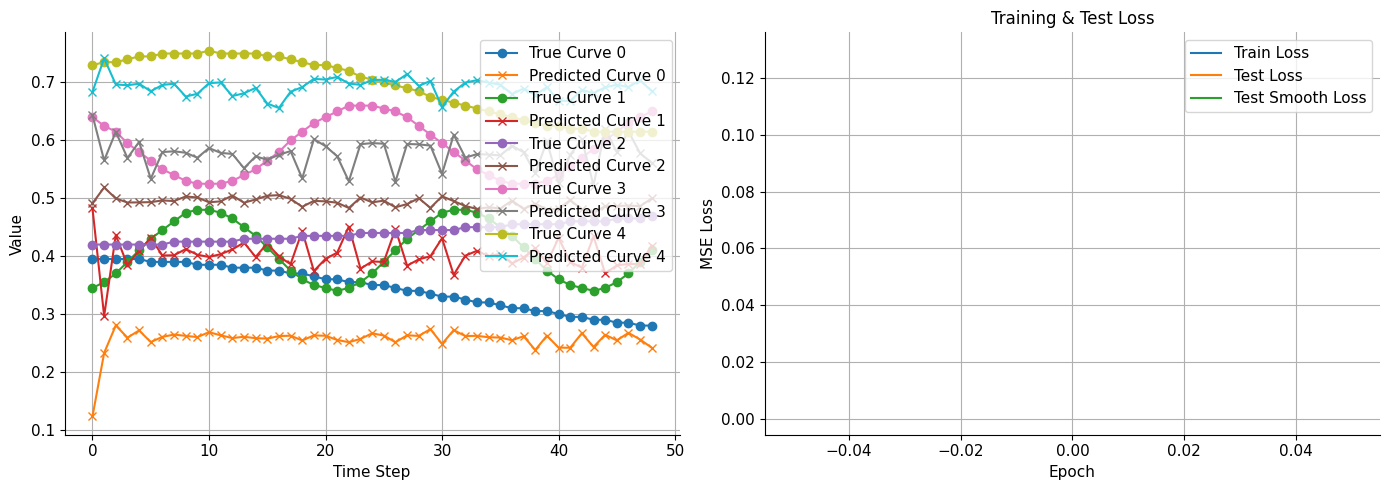

Epoch 20, Train Loss: 0.038211, Test RMSE: 0.038852, Test Smooth: 0.000081


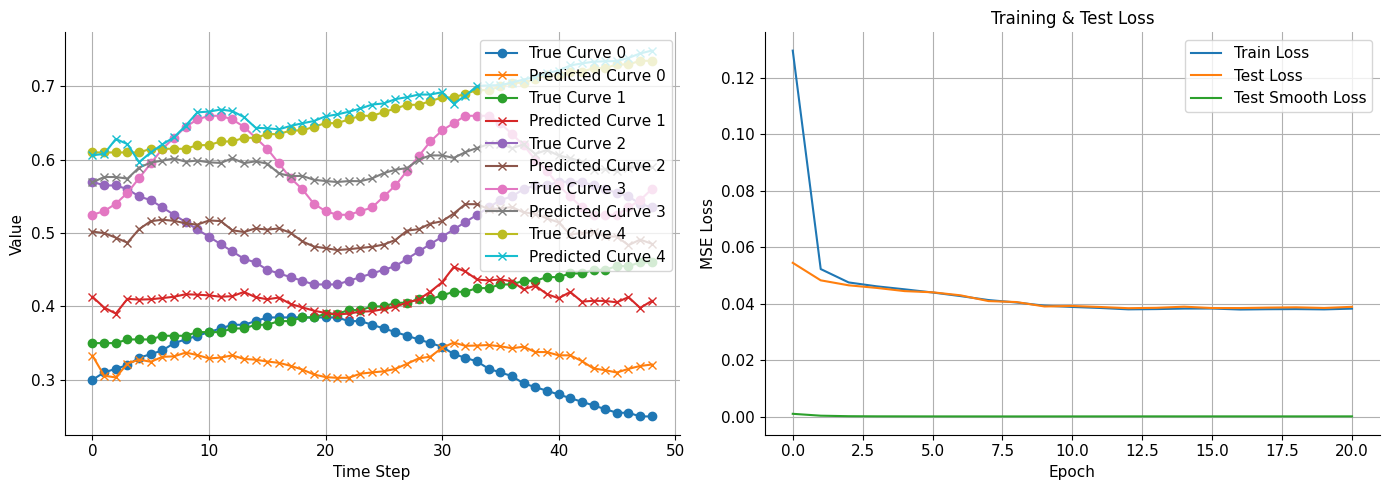

Epoch 40, Train Loss: 0.043313, Test RMSE: 0.043295, Test Smooth: 0.000037


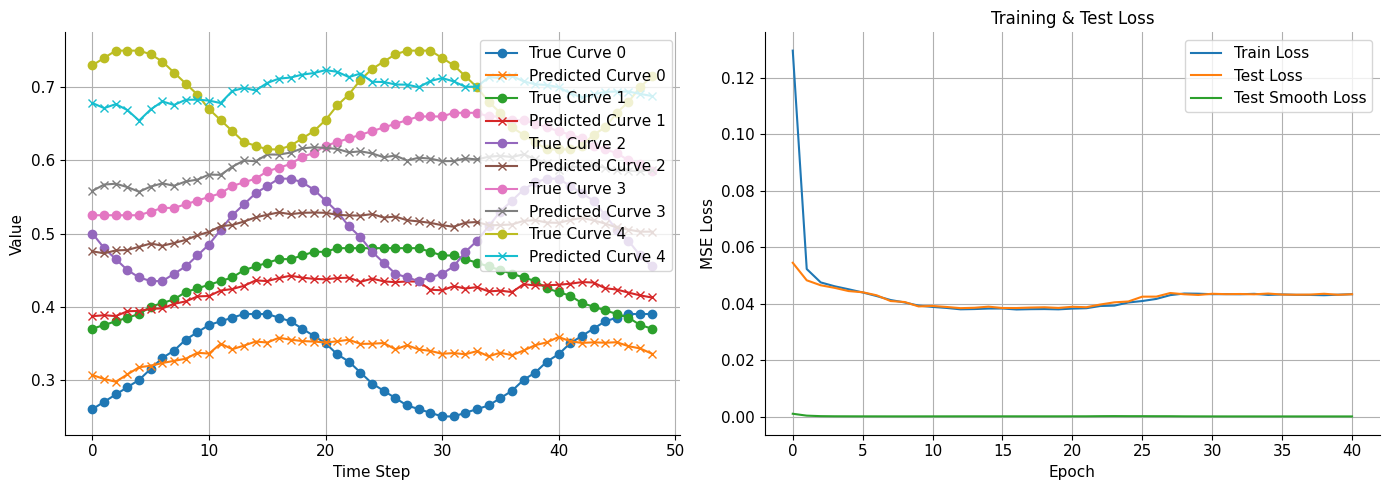

Epoch 60, Train Loss: 0.043597, Test RMSE: 0.043414, Test Smooth: 0.000033


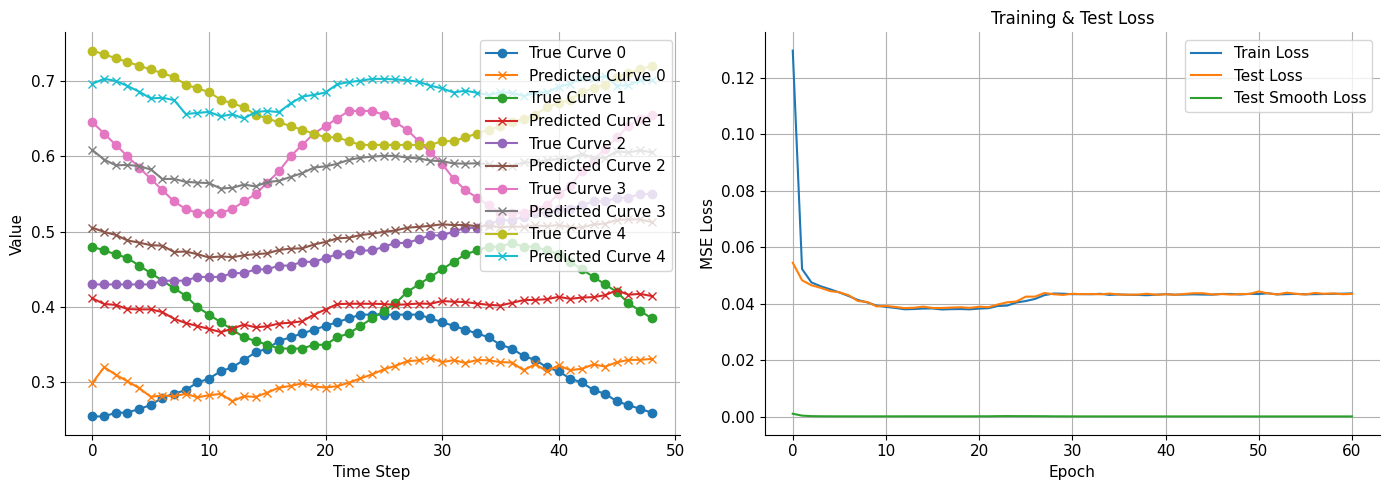

Epoch 80, Train Loss: 0.043093, Test RMSE: 0.043271, Test Smooth: 0.000039


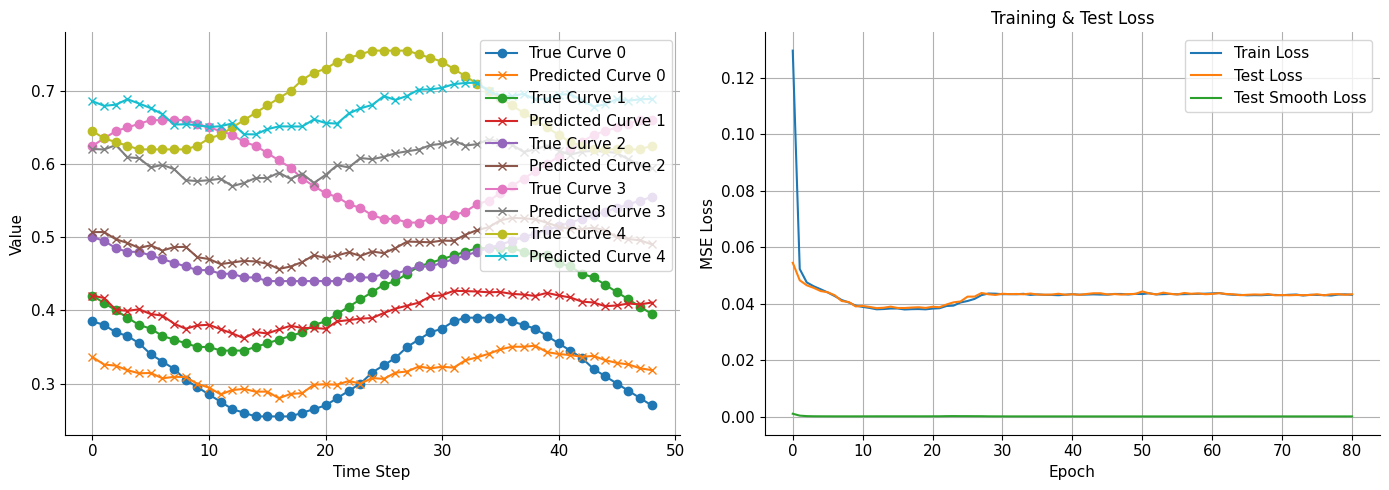

In [7]:
# -------------------------------
# Training Loop with Test Loss Evaluation
# -------------------------------
train_losses = []
test_losses = []
test_smooth_losses = []  # For tracking test smoothness loss

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0
    for X_batch, Y_batch in train_loader:
        # X_batch, Y_batch shape: (batch, seq_len, N_curves)
        current_batch_size = X_batch.size(0)
        # Initialize hidden state using the first measurement of each sample
        GTs_init = torch.zeros(current_batch_size, hidden_size)
        GTs_init[:, :N_curves] = X_batch[:, 0, :]
        GTs_init[:, N_curves:] = X_batch[:, 0, :]
        hidden = model.init_hidden(batch_size=current_batch_size, GTs_init=GTs_init)
        
        optimizer.zero_grad()
        predicted_positions = []  # List to store predictions per time step
        
        # Loop over time steps (t=0 ... seq_len-1)
        for t in range(X_batch.size(1)):
            current_measurement = Y_batch[:, t, :]  # shape: (batch, N_curves)
            assigned_measurements = []
            
            # Process Hungarian assignment per sample in the batch
            for b in range(current_batch_size):
                with torch.no_grad():
                    hidden_b = hidden[0, b]  # shape: (hidden_size,)
                    predicted_state = (pred_mat @ hidden_b.unsqueeze(1)).cpu().numpy()  # shape: (N_curves, 1)
                    meas_b = current_measurement[b].unsqueeze(0).cpu().numpy()  # shape: (1, N_curves)
                    cost_matrix = np.abs(predicted_state - meas_b)  # shape: (N_curves, N_curves)
                    row_ind, col_ind = linear_sum_assignment(cost_matrix)
                    
                    assigned = np.zeros(N_curves)
                    for r, c in zip(row_ind, col_ind):
                        assigned[r] = current_measurement[b, c].item()
                    
                    assigned_measurements.append(torch.tensor(assigned, dtype=torch.float32))
            
            # Stack assigned measurements into a batch tensor: shape (batch, N_curves)
            assigned_measurement_batch = torch.stack(assigned_measurements, dim=0)
            
            # Forward pass through the RNN model
            prediction, hidden = model(assigned_measurement_batch, hidden)
            predicted_positions.append(prediction[:, :N_curves])
        
        # Stack predictions over time: shape (batch, time_steps, N_curves)
        predicted_seq = torch.stack(predicted_positions, dim=1)
        # Target sequence: time steps 1 onward from the input batch
        target_seq = Y_batch

        # For display
        sample_pred = predicted_seq[0].detach().cpu().numpy()  # shape: (time_steps, N_curves)
        sample_target = target_seq[0].detach().cpu().numpy()     # shape: (time_steps, N_curves)

        # Compute standard MSE loss between prediction and target
        mse_loss = criterion(predicted_seq, target_seq)
        rmse_loss = torch.sqrt(mse_loss)
        # Compute smoothness loss by penalizing large differences between consecutive time steps
        diff = predicted_seq[:, 1:, :] - predicted_seq[:, :-1, :]
        smoothness_loss = torch.mean(diff ** 2)
        # Total loss is the sum of the MSE loss and the weighted smoothness loss
        loss = rmse_loss + lambda_smooth * smoothness_loss

        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # -------------------------------
    # Evaluation on Test Set
    # -------------------------------
    model.eval()
    total_test_rmse = 0.0
    total_test_smooth = 0.0
    with torch.no_grad():
        for X_batch, Y_batch in test_loader:
            current_batch_size = X_batch.size(0)
            hidden = model.init_hidden(batch_size=current_batch_size)
            hidden[0, :, :N_curves] = X_batch[:, 0, :]
            hidden[0, :, N_curves:] = X_batch[:, 0, :]
            predicted_positions = []
            
            for t in range(X_batch.size(1)):
                current_measurement = Y_batch[:, t, :]
                assigned_measurements = []
                for b in range(current_batch_size):
                    hidden_b = hidden[0, b]
                    predicted_state = (pred_mat @ hidden_b.unsqueeze(1)).cpu().numpy()
                    meas_b = current_measurement[b].unsqueeze(0).cpu().numpy()
                    cost_matrix = np.abs(predicted_state - meas_b)
                    row_ind, col_ind = linear_sum_assignment(cost_matrix)
                    assigned = np.zeros(N_curves)
                    for r, c in zip(row_ind, col_ind):
                        assigned[r] = current_measurement[b, c].item()
                    assigned_measurements.append(torch.tensor(assigned, dtype=torch.float32))
                assigned_measurement_batch = torch.stack(assigned_measurements, dim=0)
                prediction, hidden = model(assigned_measurement_batch, hidden)
                predicted_positions.append(prediction[:, :N_curves])
            
            predicted_seq = torch.stack(predicted_positions, dim=1)
            target_seq = Y_batch
            mse_val = criterion(predicted_seq, target_seq)
            rmse_val = torch.sqrt(mse_val)
            diff_val = predicted_seq[:, 1:, :] - predicted_seq[:, :-1, :]
            smooth_val = torch.mean(diff_val ** 2)
            total_test_rmse += rmse_val.item()
            total_test_smooth += smooth_val.item()
            
    avg_test_rmse = total_test_rmse / len(test_loader)
    avg_test_smooth = total_test_smooth / len(test_loader)
    test_losses.append(avg_test_rmse)
    test_smooth_losses.append(avg_test_smooth)
    
    # -------------------------------
    # Plot sample predictions and loss curves every 10 epochs
    # -------------------------------
    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Train Loss: {avg_train_loss:.6f}, Test RMSE: {avg_test_rmse:.6f}, Test Smooth: {avg_test_smooth:.6f}")
        
        # Visualization: sample prediction from last training batch
        # MSE1 = np.mean((sample_pred[:, 0] - sample_target[:, 0])**2)
        # RMSE1 = np.sqrt(MSE1)
        # MSE2 = np.mean((sample_pred[:, 1] - sample_target[:, 1])**2)
        # MSE = (MSE1 + MSE2) / 2
        
        time_steps = np.arange(0, X_batch.size(1))
        plt.figure(figsize=(14, 5))
        
        # Plot sample trajectories
        plt.subplot(1, 2, 1)
        for i in range(N_curves):
            plt.plot(time_steps, sample_target[:, i], label=f'True Curve {i}', marker='o')
            plt.plot(time_steps, sample_pred[:, i], label=f'Predicted Curve {i}', marker='x')
        plt.xlabel('Time Step')
        plt.ylabel('Value')
        plt.legend()
        # plt.title(f"Epoch {epoch}\nMSE1: {MSE1:.6f}, MSE2: {MSE2:.6f}, Avg MSE: {MSE:.6f}")
        plt.grid(True)
        
        # Plot loss curves
        plt.subplot(1, 2, 2)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(test_losses, label='Test Loss')
        plt.plot(test_smooth_losses, label='Test Smooth Loss')
        plt.xlabel("Epoch")
        plt.ylabel("MSE Loss")
        plt.title("Training & Test Loss")
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()